In [32]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_0_open_solver_1.json")

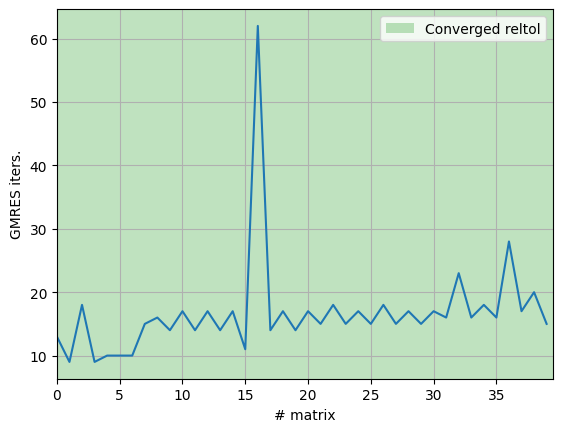

In [33]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [34]:
mat_idx = 14
get_gmres_iterations(data)[mat_idx]

17

In [35]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [36]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model
from pp_utils import make_row_col_dofs

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.09


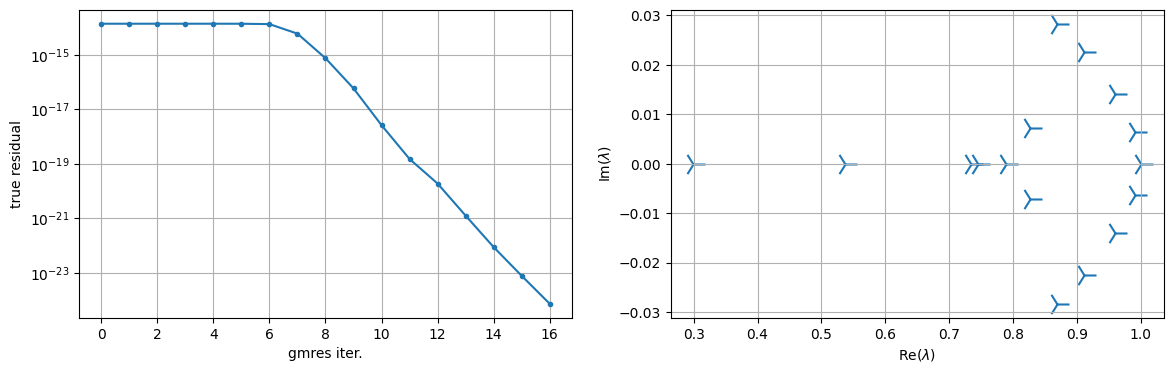

In [37]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

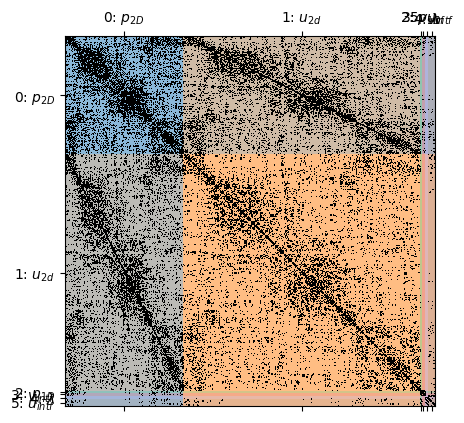

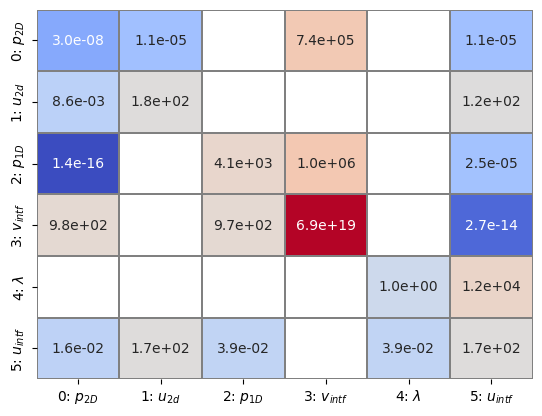

In [38]:
from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(
    mat=mat,
    row_idx=model.eq_dofs,
    col_idx=model.var_dofs,
    groups_row=model._equation_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

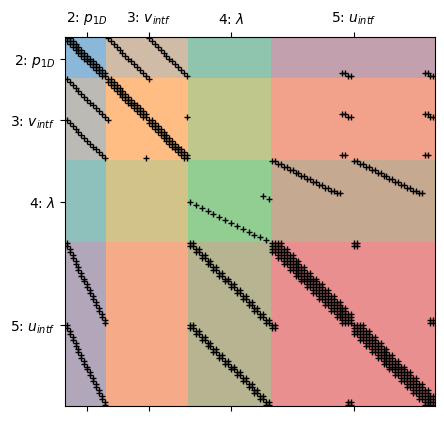

In [39]:
J[[2,3,4,5]].color_spy(True)


Solve  took: 0.07


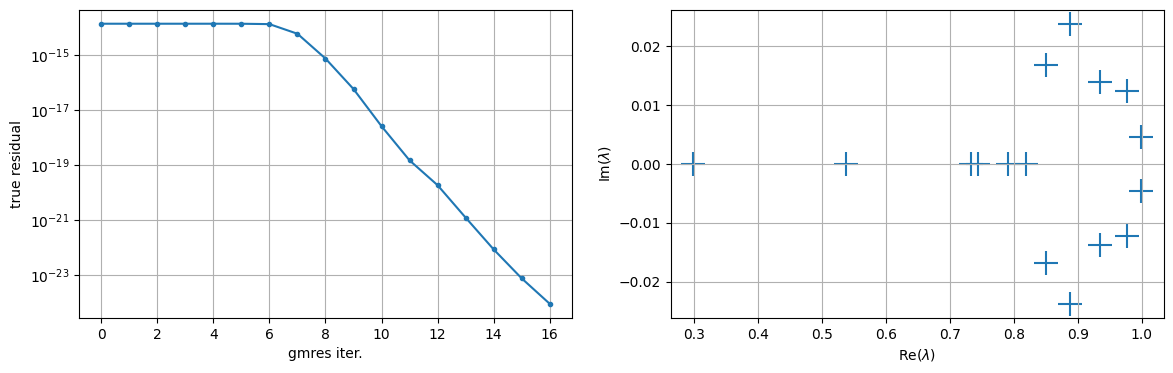

In [41]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_10 = SolveSchema(
    groups=[1],
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type="physical",
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve='direct',
    complement=SolveSchema(
        groups=[0],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
        # solve='direct'
    ),
)

schema_2345_10 = SolveSchema(
    groups=[2, 3, 4, 5],
    complement=schema_10,
)

mat_permuted, prec = make_solver(schema=schema_2345_10, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

ILU on block 3 adds imaginary parts to eigenvalues

When there are more than one fracture, ILU0 is not enough.

Solve  took: 0.12


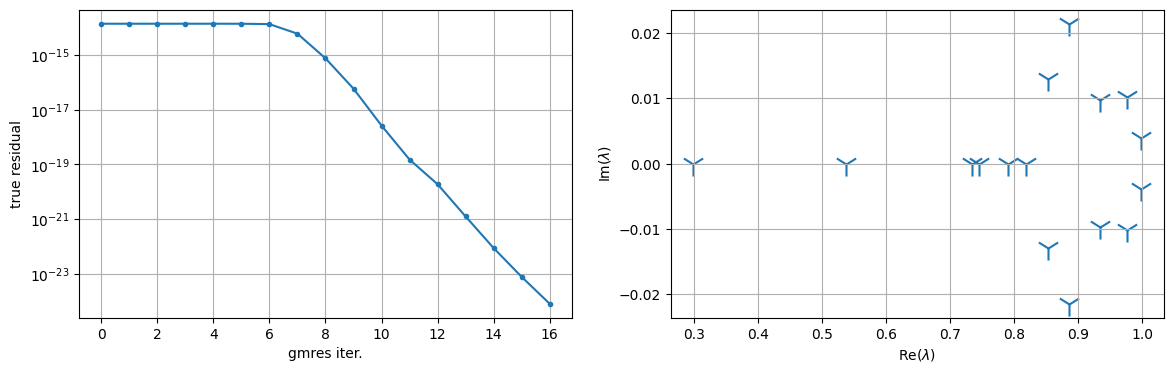

In [42]:
schema_245_10 = SolveSchema(
    groups=[2, 4, 5],
    complement=schema_10,
)

schema_3_245_10 = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=schema_245_10,
)

mat_permuted, prec = make_solver(schema=schema_3_245_10, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.07


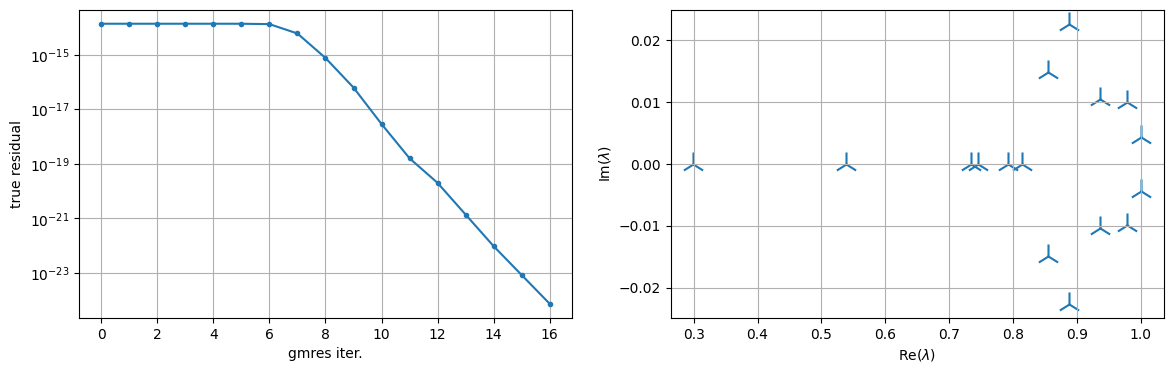

In [43]:
schema_45_10 = SolveSchema(
    groups=[4, 5],
    complement=schema_10,
)

schema_2_45_10 = SolveSchema(
    groups=[2],
    complement=schema_45_10,
    solve=lambda bmat: PetscAMGFlow(bmat.mat),
    invertor=lambda bmat: inv(bmat.mat),  # BAD (ok if sticking)
)

schema_3_2_45_10 = SolveSchema(
    groups=[3],
    complement=schema_2_45_10,
    solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
)


mat_permuted, prec = make_solver(schema=schema_3_2_45_10, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Approximating lower-dim flow with the diagonal or row sum is a bad idea.

What if we solve 2d and 1d pressure together?

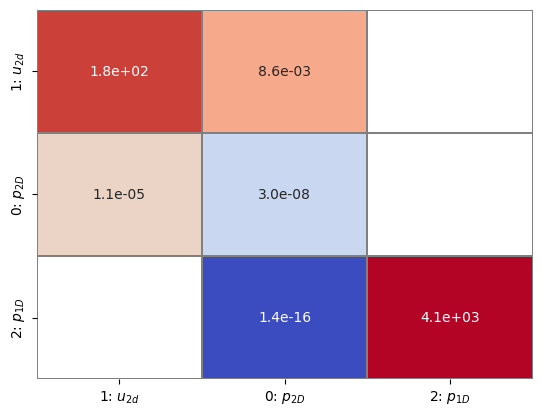

In [44]:
J[[1, 0, 2]].plot_max()

Solve  took: 0.39


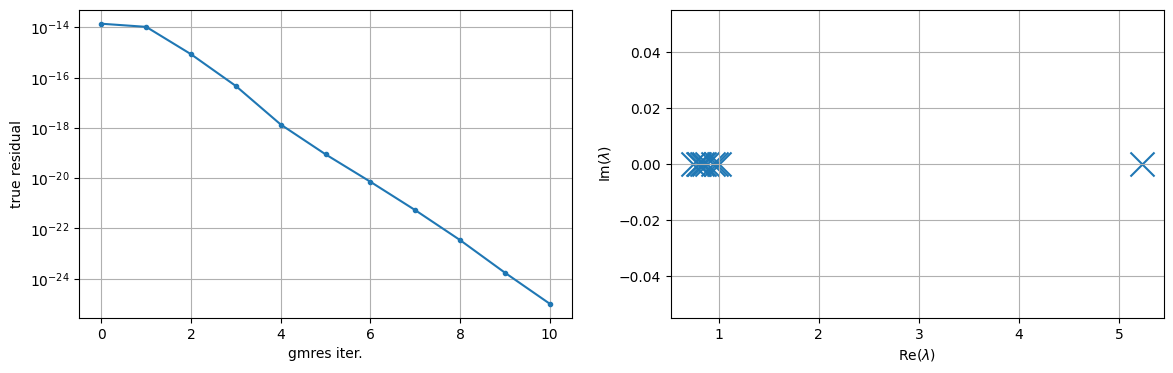

In [84]:
from pp_utils import get_fixed_stress_stabilization_nd

schema_02 = SolveSchema(
    groups=[0, 2],
    # solve=lambda bmat: PetscAMGFlow(bmat.mat),
    solve='direct'
)

solve_1_02 = SolveSchema(
    groups=[1],
    complement=schema_02,
    invertor=lambda: get_fixed_stress_stabilization_nd(model),
    invertor_type="physical",

    # invertor='direct',
    
    # solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    solve='direct'
)

schema_45_1_02 = SolveSchema(
    groups=[4, 5],
    complement=solve_1_02,
)

schema_3_45_10_2 = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=schema_45_1_02,

    # only_complement=True
)

mat_permuted, prec = make_solver(schema=schema_3_45_10_2, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

When we invert 45, it adds eigenvalue 7 to the fixed stress matrix. This can indicate that the fs approx is not enough.

If we remove the block 2 (only nd F-S), it disappears.

If sticking, no bad eigenvalues appear!

This effect is not observed when we invert only 5.

Physical approximation of J55:

TPFA: $J_{55} \cdot d u_{\Gamma} = (2 \mu + \lambda) \dfrac{2}{h} d u_{\Gamma}$

Using this approximation of 45 to build the full solver

Solve  took: 2.32


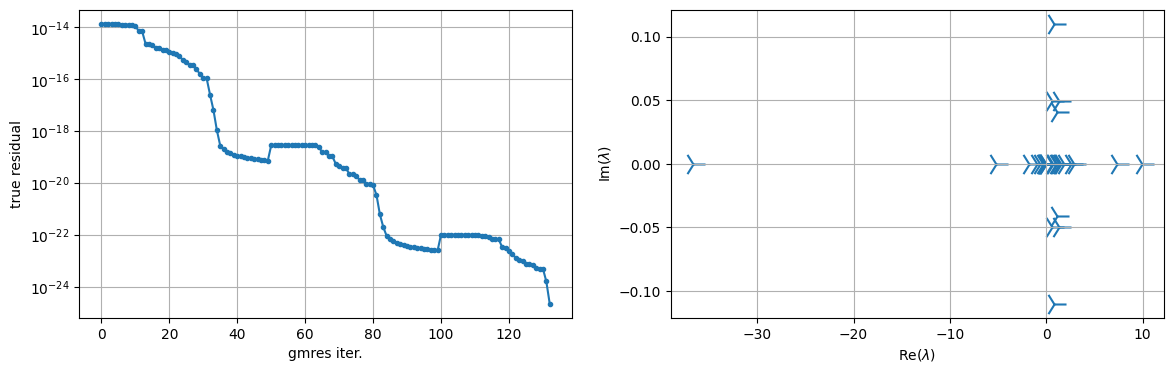

In [83]:
from pp_utils import reorder_J44
from mat_utils import inv_block_diag_2x2

# schema_02 = SolveSchema(
#     groups=[0, 2],
#     # solve=lambda bmat: PetscAMGFlow(bmat.mat),
#     solve="direct",
# )

solve_1_02 = SolveSchema(
    groups=[1],
    # complement=schema_02,
    invertor=lambda: get_fixed_stress_stabilization_nd(model),
    invertor_type="physical",
    # invertor='direct',
    # solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    solve="direct",
)

reorder = reorder_J44(model)
inv_reorder = np.argsort(reorder)

schema_5_4_1_02 = SolveSchema(
    groups=[5],
    solve=lambda bmat: inv(bmat.mat),
    invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: inv_block_diag_2x2(bmat.mat[reorder])[:, inv_reorder],
        # solve="direct",
        complement=solve_1_02,
    ),
)

# schema_3_5_4_1_02 = SolveSchema(
#     groups=[3],
#     solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=0),
#     invertor=lambda bmat: extract_diag_inv(bmat.mat),
#     complement=schema_5_4_1_02,
#     # only_complement=True
# )

mat_permuted, prec = make_solver(schema=schema_5_4_1_02, mat_orig=J)
# mat_permuted.color_spy()
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# mat_permuted.color_spy(False)
# mat_permuted.slice_domain(1, 1).data

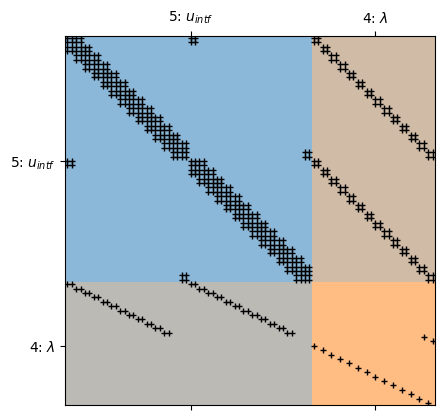

In [59]:
mat_permuted.color_spy()

In [55]:
inv_reorder

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27,  0,  2,  4,
        6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26])

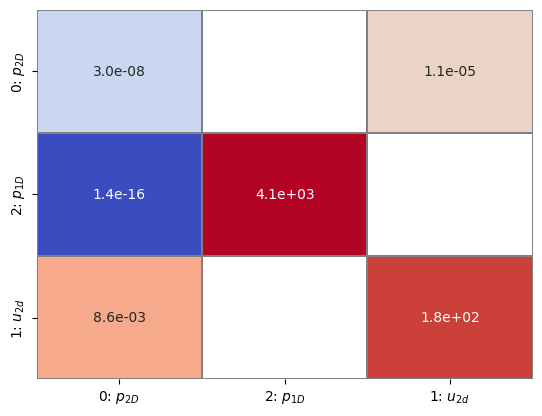

In [31]:
J[[0, 2, 1]].plot_max()

In [32]:
mu_lame = model.solid.shear_modulus()
lambda_lame = model.solid.lame_lambda()
alpha_biot = model.solid.biot_coefficient()
dim = model.nd

l_phys = alpha_biot**2 / (2 * mu_lame / dim + lambda_lame)
l_min = alpha_biot**2 / (4 * mu_lame + 2 * lambda_lame)

l_factor = 0.6
diagonal_approx_nd = l_min * (l_phys / l_min) ** l_factor
subdomains = model.mdg.subdomains(dim=dim)
cell_volumes = subdomains[0].cell_volumes
diagonal_approx_nd *= cell_volumes

density = model.fluid_density(subdomains).value(model.equation_system)
diagonal_approx_nd *= density

dt = model.time_manager.dt
diagonal_approx_nd /= dt

diagonal_approx_nd

array([7.57548697e-09, 8.83023239e-09, 7.27224603e-09, 8.27591002e-09,
       8.64796612e-09, 6.87598288e-09, 8.86154240e-09, 8.14353723e-09,
       7.28508650e-09, 7.45500917e-09, 8.17510104e-09, 6.95525957e-09,
       7.03814906e-09, 5.93260201e-09, 8.16631509e-09, 6.95966996e-09,
       7.02222498e-09, 7.81540533e-09, 7.48974960e-09, 6.62244307e-09,
       7.54940352e-09, 6.48679802e-09, 7.65627004e-09, 7.10905969e-09,
       7.15736117e-09, 6.47022516e-09, 7.07190544e-09, 6.54213983e-09,
       7.11202696e-09, 7.60804693e-09, 5.77807169e-09, 6.42063984e-09,
       5.46699156e-09, 6.46993175e-09, 6.90725554e-09, 7.22834770e-09,
       7.48387285e-09, 7.23555484e-09, 6.17241636e-09, 5.87438560e-09,
       6.51283771e-09, 5.37932403e-09, 7.27437804e-09, 5.44588156e-09,
       6.72277255e-09, 6.60148755e-09, 6.69615153e-09, 7.02204605e-09,
       6.58408081e-09, 5.57524254e-09, 6.31467217e-09, 7.07195772e-09,
       5.40488715e-09, 4.94157595e-09, 6.88713254e-09, 6.84403110e-09,
      

In [33]:
mu_lame = 0
lambda_lame = 1 / model.fluid.compressibility()
alpha_biot = 1
dim = 1

l_phys = alpha_biot**2 / (2 * mu_lame / dim + lambda_lame)
l_min = alpha_biot**2 / (4 * mu_lame + 2 * lambda_lame)

l_factor = 0.6
diagonal_approx_nd = l_min * (l_phys / l_min) ** l_factor
sd_1d = model.mdg.subdomains(dim=dim)
cell_volumes = sd_1d[0].cell_volumes
specific_volume = model.specific_volume(sd_1d).value(model.equation_system)
diagonal_approx_nd *= cell_volumes * specific_volume

density = model.fluid_density(subdomains).value(model.equation_system)
diagonal_approx_nd *= density

dt = model.time_manager.dt
diagonal_approx_nd /= dt

diagonal_approx_nd

ValueError: operands could not be broadcast together with shapes (14,) (998,) (14,) 